# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# load weekly sales dataset

filename = "online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [3]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [4]:
df['sales'].min(),df['sales'].max()

(0.0, 372946.26)

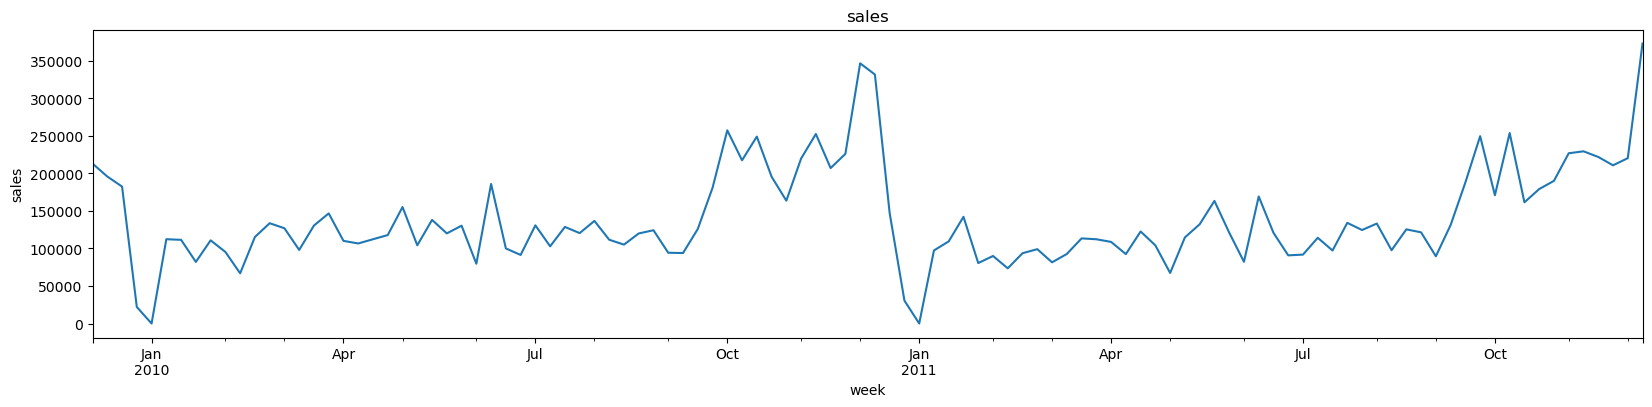

In [5]:
# Plot the time series
df['sales'].plot(figsize=(20, 4))

# Add title
plt.title('sales')

# the y axis label
plt.ylabel('sales')

plt.show()

## Missing data

Check if there are missing values in the time series.

In [6]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

In [7]:
df.index.isnull().sum()

0

## Seasonality

Does the time series show any obvious seasonal pattern?

Ans: we can clearly see a yearly seasonal pattern in the time series above. The sales increase in december for each year

# Feature engineering

Now, let's begin to tabularize the data.

### Extract the time related features

In [8]:
df["Month"] = df.index.month
df["Day_of_week"] = df.index.day_of_week

# find out if it is a weekend.
df["is_weekend"] = np.where(df["Day_of_week"]>4, 1, 0)

# Show new variables
df.head()

,sales,Month,Day_of_week,is_weekend
week,,,,
2009-12-06,213000.35,12,6,1
2009-12-13,195810.04,12,6,1
2009-12-20,182396.74,12,6,1
2009-12-27,22007.77,12,6,1
2010-01-03,0.00,1,6,1


In [9]:
df.tail()

,sales,Month,Day_of_week,is_weekend
week,,,,
2011-11-13,229378.01,11,6,1
2011-11-20,221870.29,11,6,1
2011-11-27,210741.76,11,6,1
2011-12-04,220213.99,12,6,1
2011-12-11,372946.26,12,6,1


## Lag features

### lag of 1 week

In [10]:
# raw time series
variables = ["sales"]

# Shift the data forward 1 month.
tmp = df[variables].shift(periods=1, freq='W')

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 4)
data size after
(106, 5)


,sales,Month,Day_of_week,is_weekend,sales_lag_1
week,,,,,
2009-12-06,213000.35,12,6,1,NaN
2009-12-13,195810.04,12,6,1,213000.35
2009-12-20,182396.74,12,6,1,195810.04
2009-12-27,22007.77,12,6,1,182396.74
2010-01-03,0.00,1,6,1,22007.77


### lag of 4 weeks

In [11]:
# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr.
tmp = df[variables].shift(periods=4, freq='W')

# Names for the new variables.
tmp.columns = [v + "_lag_4" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 5)
data size after
(106, 6)


,sales,Month,Day_of_week,is_weekend,sales_lag_1,sales_lag_4
week,,,,,,
2009-12-06,213000.35,12,6,1,NaN,NaN
2009-12-13,195810.04,12,6,1,213000.35,NaN
2009-12-20,182396.74,12,6,1,195810.04,NaN
2009-12-27,22007.77,12,6,1,182396.74,NaN
2010-01-03,0.00,1,6,1,22007.77,213000.35


### lag of 52 weeks

# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr.
tmp = df[variables].shift(periods=52, freq='W')

# Names for the new variables.
tmp.columns = [v + "_lag_52" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

In [12]:
df.isnull().sum()

sales          0
Month          0
Day_of_week    0
is_weekend     0
sales_lag_1    1
sales_lag_4    4
dtype: int64

## rolling window average

In [13]:
tmp = df[variables].rolling(window=4).mean()  # Average the last 4 weeks

# Names for the new variables.
tmp.columns = [v + "_window" for v in variables]

# view of the result
tmp.head(10)
    



,sales_window
week,
2009-12-06,NaN
2009-12-13,NaN
2009-12-20,NaN
2009-12-27,153303.72500
2010-01-03,100053.63750
2010-01-10,79180.84000
2010-01-17,61446.77250
2010-01-24,76461.16275
2010-01-31,104158.81050


In [14]:
# Join the new variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)



data size before
(106, 6)
data size after
(106, 7)


In [15]:
df[["sales", "sales_window"]].head()

,sales,sales_window
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,NaN
2009-12-20,182396.74,NaN
2009-12-27,22007.77,153303.7250
2010-01-03,0.00,100053.6375


In [16]:
df.head()

,sales,Month,Day_of_week,is_weekend,sales_lag_1,sales_lag_4,sales_window
week,,,,,,,
2009-12-06,213000.35,12,6,1,NaN,NaN,NaN
2009-12-13,195810.04,12,6,1,213000.35,NaN,NaN
2009-12-20,182396.74,12,6,1,195810.04,NaN,NaN
2009-12-27,22007.77,12,6,1,182396.74,NaN,153303.7250
2010-01-03,0.00,1,6,1,22007.77,213000.35,100053.6375


### Periodic features

In [17]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["Month"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [18]:
cyclical_vars = [var for var in df.columns if "sin" in var or "cos" in var]

df[cyclical_vars].head()

,Month_sin,Month_cos
week,,
2009-12-06,-2.449294e-16,1.000000
2009-12-13,-2.449294e-16,1.000000
2009-12-20,-2.449294e-16,1.000000
2009-12-27,-2.449294e-16,1.000000
2010-01-03,5.000000e-01,0.866025


In [19]:
df.head()

,sales,Month,Day_of_week,is_weekend,sales_lag_1,sales_lag_4,sales_window,Month_sin,Month_cos
week,,,,,,,,,
2009-12-06,213000.35,12,6,1,NaN,NaN,NaN,-2.449294e-16,1.000000
2009-12-13,195810.04,12,6,1,213000.35,NaN,NaN,-2.449294e-16,1.000000
2009-12-20,182396.74,12,6,1,195810.04,NaN,NaN,-2.449294e-16,1.000000
2009-12-27,22007.77,12,6,1,182396.74,NaN,153303.7250,-2.449294e-16,1.000000
2010-01-03,0.00,1,6,1,22007.77,213000.35,100053.6375,5.000000e-01,0.866025


## Drop missing data
When creating lag and window features, we introduced missing data.

In [20]:
df.isnull().sum() / len(df)

sales           0.000000
Month           0.000000
Day_of_week     0.000000
is_weekend      0.000000
sales_lag_1     0.009434
sales_lag_4     0.037736
sales_window    0.028302
Month_sin       0.000000
Month_cos       0.000000
dtype: float64

In [21]:
print("data size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

data size before
(106, 9)
data size after
(102, 9)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [22]:
# Define the split date as the last week of September
split_date = '2011-09-26'

X_train = df[df.index <= split_date]
X_test = df[df.index > split_date]

X_train.shape, X_test.shape

((91, 9), (11, 9))

In [23]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [24]:
print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  45844.30745262792
test rmse:  65327.34284108387


## Machine Learning

## Random Forest

In [25]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [26]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  26441.472296500426
test rmse:  48836.72980114501


## Linear Regression
Random Forest regression models are not very good at extrapolating values beyond those observed in the data. So let's now train a Lasso regression for comparison.

In [27]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [28]:
print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  38557.034235824605
test rmse:  51230.16409450235


Text(0, 0.5, 'Importance')

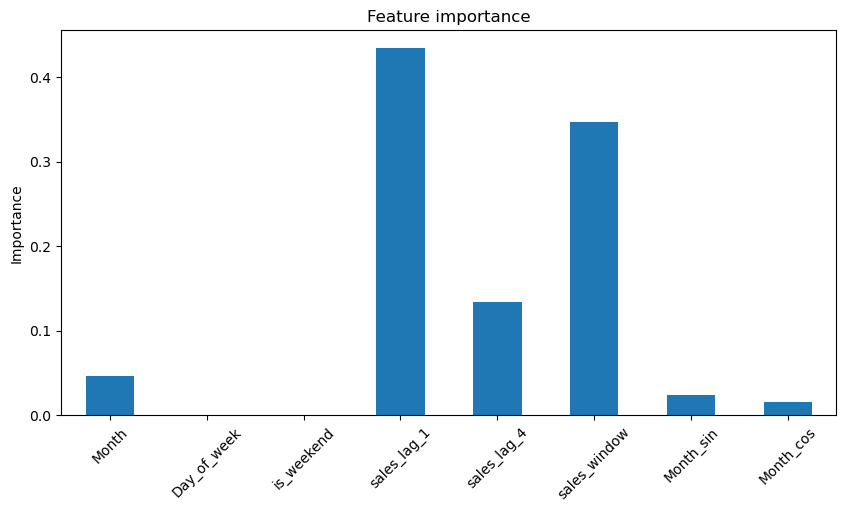

In [29]:
# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")